In [ ]:
#CV trained from 2 unbiased traj, 210 distances from Luigi

In [1]:
import mlcvs
import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import pandas as pd

# delete outputs of simulations from `folder``
def clean(folder='./'):
    subprocess.run("rm bck.* COLVAR KERNELS alanine.*", cwd=folder, shell=True)

# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

In [2]:
# Define a few plotting functions

def plot_ramachandran(x,y,z,scatter=None, ax=None):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title(f'Ramachandran plot')

    # Plot countour plot
    h = ax.hexbin(x,y,C=z,cmap='fessa')
    cbar = plt.colorbar(h,ax=ax)
    cbar.set_label(f'Deep-LDA CV')

    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        s = s.squeeze(1).detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)

In [53]:
from mlcvs.utils.io import load_dataframe
# load state A and assign label 0
folder = '/home/vrizzi@iit.local/Chignolin/multiT/unbiased_folded/'
colvarA = load_dataframe(folder+"COLVARcut")
colvarA['state']=np.full(len(colvarA),'A')
colvarA['label']=np.full(len(colvarA),0)

# load stateB and assign label 1
folder = '/home/vrizzi@iit.local/Chignolin/multiT/unbiased_unfolded/'
colvarB = load_dataframe(folder+"COLVARcut")
colvarB['state']=np.full(len(colvarB),'B')
colvarB['label']=np.full(len(colvarB),1)

# concatenate data into a single dataframe
colvar = pd.concat([colvarA,colvarB.reset_index(drop=True)])

# create training dataset 
X = colvar.filter(regex='dd_').values
#X = colvar.filter(regex='da1|da2|da3|da4|da5|da6|da7|da8|da9|dc10|dc11|dc12').values
#X = colvar.filter(regex='dd1|dd2|dd3|dd4|dc10|dc11').values
#X = colvar.filter(regex='dd1|dd2').values
y = colvar['label'].values
print(X.shape)

# transform them into torch.tensors 
X = torch.Tensor(X)
y = torch.Tensor(y)

(619998, 210)
(219999, 3)
(399999, 3)


In [4]:
input_names = colvar.filter(regex='dd1|dd2|dd3|dd4|dd5|dd6|dd7|dd8|dd9|dd10|dd11|dd12').columns.values
print(input_names)

['dd1' 'dd2' 'dd3' 'dd4' 'dd5' 'dd6' 'dd7' 'dd8' 'dd9' 'dd10' 'dd11'
 'dd12']


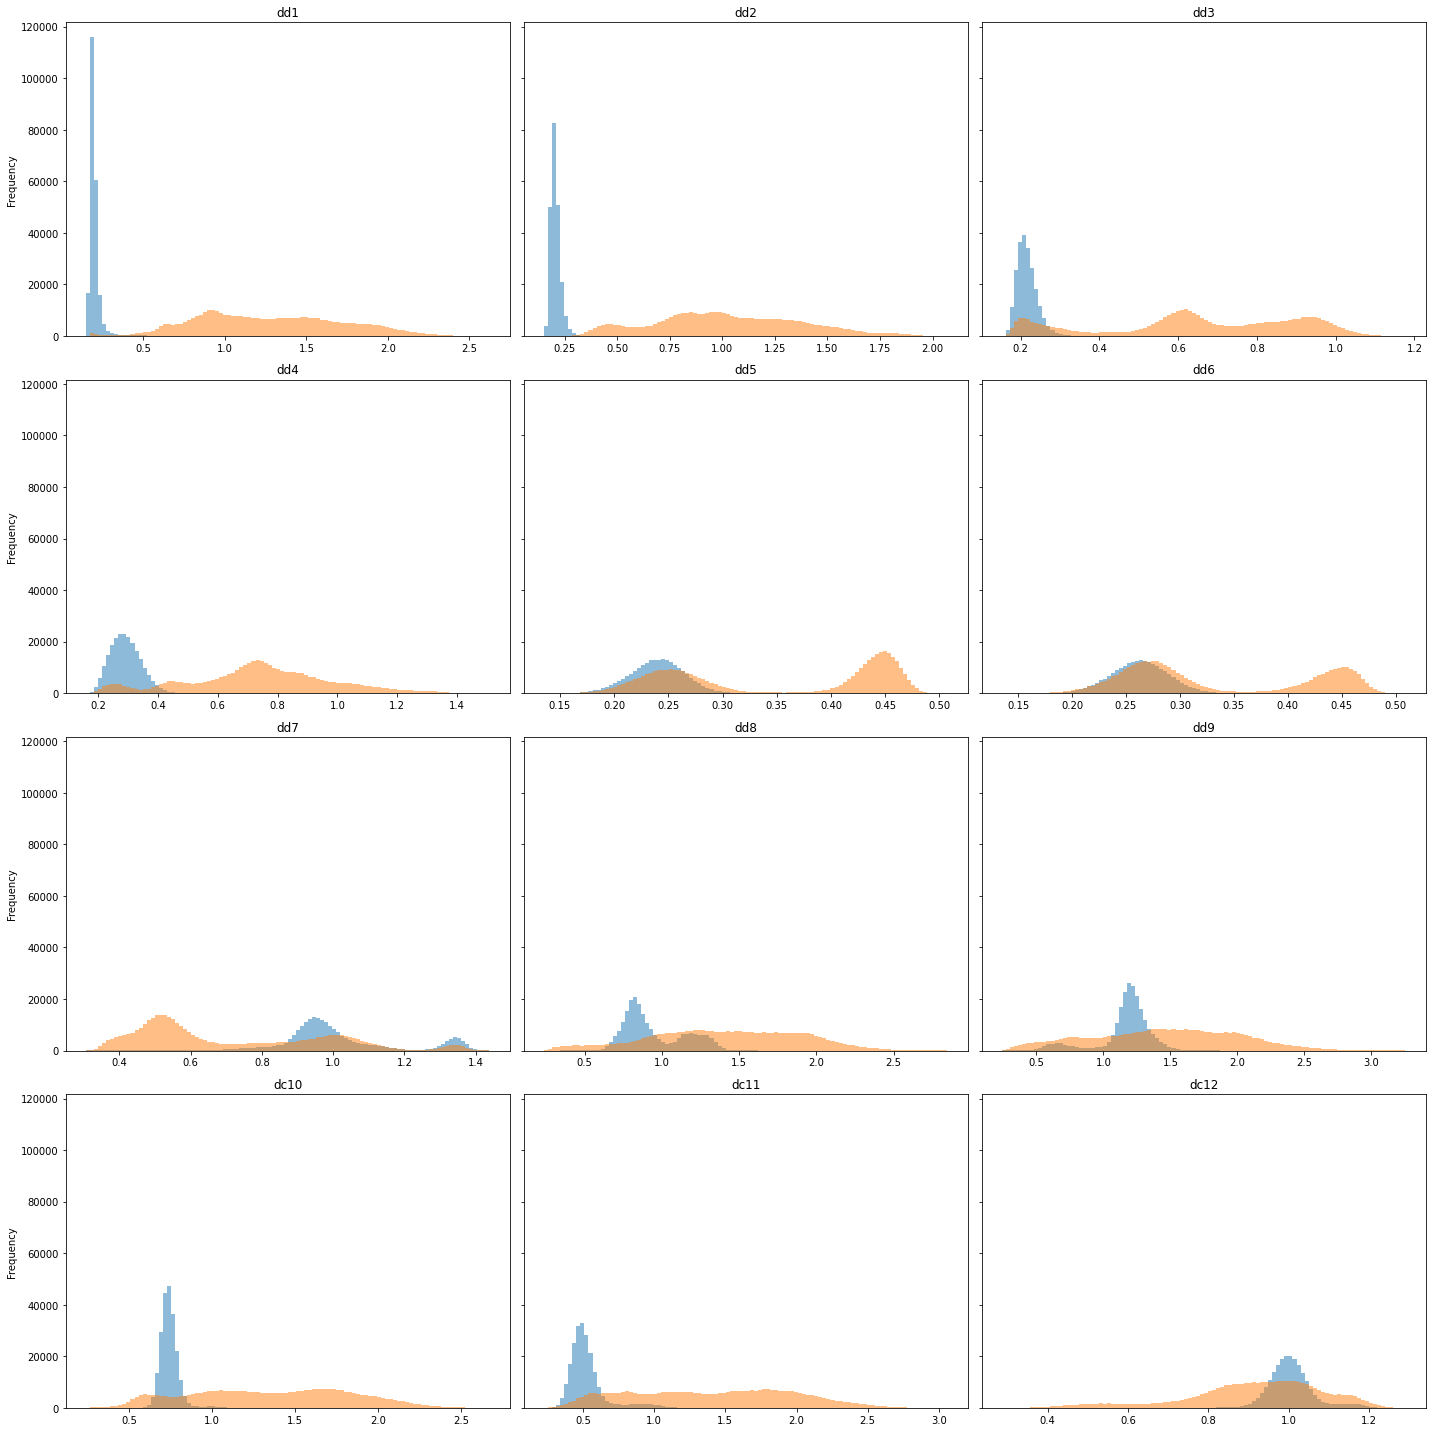

In [38]:
#descriptors_names = colvar.filter(regex='d_').columns.values
descriptors_names = colvar.filter(regex='dd1|dd2|dd3|dd4|dd5|dd6|dd7|dd8|dd9|dc10|dc11|dc12').columns.values

#fig,axs = plt.subplots(5,9,figsize=(20,10),sharey=True)
fig,axs = plt.subplots(4,3,figsize=(20,20),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    colvar.pivot(columns='state')[desc].plot.hist(bins=100,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

In [68]:
from scipy.stats import wasserstein_distance

XA = colvarA.filter(regex='dd_').values
XB = colvarB.filter(regex='dd_').values
print(XA.shape)
print(XB.shape)

for i in range(XA.shape[1]):
    print(i, wasserstein_distance(XA[:200000,i],XB[:200000,i]))

(219999, 210)
(399999, 210)
0 0.39893682876
1 0.8556144059100003
2 0.00018041268499999978
3 0.14972979355500002
4 0.24376156717500005
5 0.200030155285
6 0.6229788132399999
7 0.9204341109599999
8 0.5260407388899998
9 0.20981149181500003
10 0.11876267047000001
11 0.116557190755
12 0.8683099084250003
13 0.5637328485450003
14 0.038936483565000006
15 0.088074440795
16 0.6202634698200001
17 0.8383811254350002
18 0.017971542425
19 0.009233715055
20 0.027235942665
21 0.81969023899
22 0.8238180717950001
23 0.15634960145499996
24 0.11902627691000002
25 0.54205892239
26 1.865416499999998e-05
27 0.31898258737500007
28 0.8332377516899999
29 0.8378556924549998
30 0.022954116125000004
31 0.019165788790000002
32 0.16259506816999997
33 0.22679998593499995
34 0.23122058167
35 0.6461836053200001
36 0.4117509553
37 0.54938085458
38 0.743922891765
39 0.012082603145000004
40 0.265717028035
41 0.94598816223
42 0.26628649196499987
43 0.12550317581999998
44 0.3136478399
45 0.5075594814450001
46 1.0189092748149

In [54]:
from torch.utils.data import TensorDataset,random_split
from mlcvs.utils.data import FastTensorDataLoader

dataset = TensorDataset(X,y)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_data, valid_data = random_split(dataset,[train_size,valid_size])
train_loader = FastTensorDataLoader(train_data,batch_size=0,shuffle=True) # here 0 means to use a single batch
valid_loader = FastTensorDataLoader(valid_data)

In [55]:
from mlcvs.lda import DeepLDA_CV

#------------- PARAMETERS -------------
nodes             = [X.size(1),100,60,20,4]
activation        = 'tanh'

lrate             = 0.0002
sw_reg            = 0.05
l2_reg            = 1e-5

num_epochs        = 10000
earlystop         = True
es_patience       = 20
es_consecutive    = True
es_min_delta      = 0.1

log_every         = 10
#--------------------------------------

# DEVICE: check if there is a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL: initialize the DeepLDA CV object
model = DeepLDA_CV(nodes,activation)
model.to(device)

# OPTIMIZER: here we use adam
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)
model.set_optimizer(opt)
# set criterion for stopping the learning --> avoid overfitting
model.set_earlystopping(patience=es_patience,consecutive=es_consecutive,min_delta=es_min_delta)

# REGULARIZATION: add regularization to the calculation of the S_w matrix
model.set_regularization(sw_reg=sw_reg)

# TRAIN: fit the model to maximize Fisher's discriminant ratio
model.fit(train_loader,valid_loader, 
            standardize_inputs = True, 
            standardize_outputs = False,
            log_every=log_every)

Epoch Train Loss  Valid Loss  
10    -27.962 -27.934 
20    -38.196 -38.129 
30    -40.046 -40.123 
40    -41.466 -41.466 
50    -41.623 -41.588 
60    -42.187 -42.186 
70    -42.763 -42.754 
80    -43.621 -43.590 
90    -44.719 -44.684 
100   -45.879 -45.816 
110   -46.919 -46.826 
120   -47.889 -47.765 
130   -48.819 -48.665 
140   -49.712 -49.530 
150   -50.613 -50.402 
160   -51.548 -51.308 
170   -52.529 -52.263 
180   -53.558 -53.271 
190   -54.631 -54.330 
200   -55.730 -55.426 
210   -56.820 -56.524 
220   -57.844 -57.564 
230   -58.745 -58.487 
240   -59.484 -59.250 
250   -60.060 -59.849 
260   -60.499 -60.310 
270   -60.836 -60.664 
280   -61.096 -60.940 
290   -61.301 -61.157 
300   -61.465 -61.332 
310   -61.599 -61.474 
320   -61.709 -61.592 
330   -61.802 -61.691 
340   -61.881 -61.776 
350   -61.950 -61.850 
360   -62.010 -61.914 
370   -62.063 -61.970 
380   -62.110 -62.020 
INFO: Early stopping
387   -62.140 -62.052 


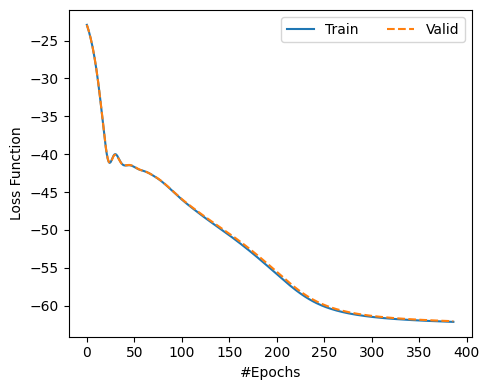

In [56]:
fig, ax = plt.subplots(figsize=(5,4),dpi=100)

loss_train = [x.cpu().numpy() for x in model.loss_train]
loss_valid = [x.cpu().numpy() for x in model.loss_valid]

# Loss function
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

#if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

In [65]:
folder = '/home/vrizzi@iit.local/Chignolin/multiT/deeplda/'

# export model
model.export(folder)

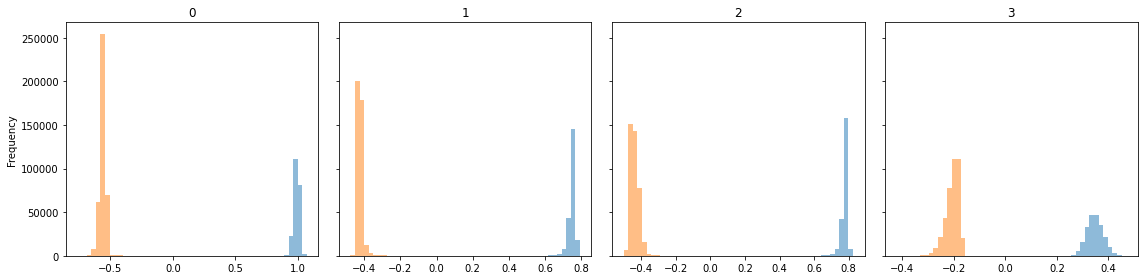

In [58]:
model.output_hidden=True
with torch.no_grad():
    hidden = model(X).numpy()
df = pd.DataFrame( hidden )
df ['label'] = y
model.output_hidden=False

# Plot histogram in the two state
fig,axs = plt.subplots(1,nodes[-1],figsize=(16,4),sharey=True)

hidden_names = [i for i in range(nodes[-1])]

for ax,desc in zip(axs.flatten(),hidden_names):
    df.pivot(columns='label')[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

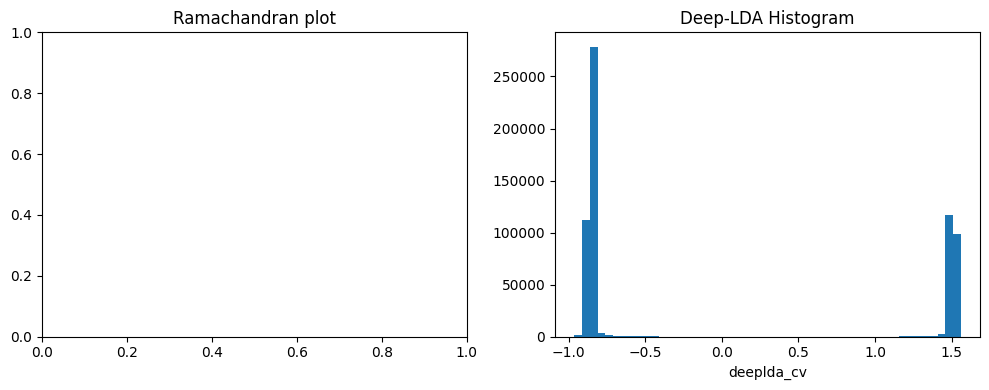

In [59]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

axs[0].set_title('Ramachandran plot')
with torch.no_grad():
    s = model(X)
    
#plot_ramachandran(colvar['phi'],colvar['psi'],s,ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Deep-LDA Histogram')
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )

plt.tight_layout()

/tmp/ipykernel_1158001/834135440.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(input_names,fontsize=9)


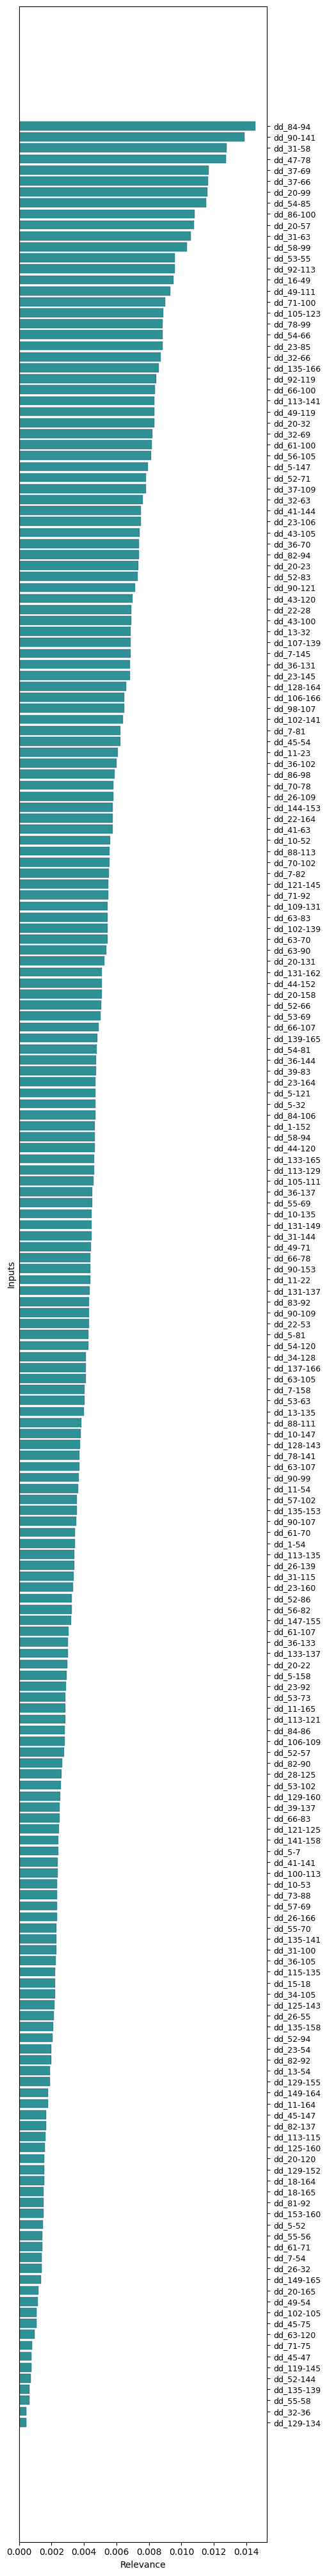

In [66]:
# parameters
multiply_by_stddev = True #whether to multiply derivatives by std dev of inputs
order_by_importance = True #plot results ordered by importance

#input names 
input_names = colvar.filter(regex='dd_').columns.values
#input_names = colvar.filter(regex='dd1|dd2|dd3|dd4|dd5|dd6|dd7|dd8|dd9|dd10|dd11|dd12').columns.values
n_input = len(input_names)

#init arrays
in_num=np.arange(n_input)
rank=torch.zeros(n_input)

#compute input std dev
if multiply_by_stddev:
    in_std=torch.std(X,axis=0).numpy()

#compute the derivatives of the outputs w.r.t. inputs over all training set
for (x,Y) in train_loader:    
    x.requires_grad=True
    for x_i,y_i in zip(x,Y):
        # calculate cv 
        s_i = model(x_i) 
        # calculate derivatives
        grad_i = torch.autograd.grad(s_i,x_i)
        # accumulate them
        rank += grad_i[0].abs()

rank = rank.numpy()

#multiply by std dev
if multiply_by_stddev:
    rank = rank * in_std

#normalize to 1
rank/= np.sum(rank)

#sort
if order_by_importance:
    index= rank.argsort()
    input_names = input_names[index]
    rank = rank[index]

#plot
fig=plt.figure(figsize=(5,0.25*n_input), dpi=100)
ax = fig.add_subplot(111)

if order_by_importance:
    ax.barh(in_num, rank,color='fessa1',edgecolor = 'fessa0',linewidth=0.3)
    ax.set_yticklabels(input_names,fontsize=9)
else:
    ax.barh(in_num[::-1], rank[::-1],color='fessa1',edgecolor = 'fessa0',linewidth=0.3)
    ax.set_yticklabels(input_names[::-1],fontsize=9)

ax.set_xlabel('Relevance')
ax.set_ylabel('Inputs')
ax.set_yticks(in_num)
ax.yaxis.tick_right()